<h2> Russel Wilcox-Cline </h2>
<h3> Applied Stochastic Processes: Homework 4 </h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import factorial
import sympy as sym
from sympy import init_printing

init_printing()
%matplotlib inline

<h4> Part a </h4>

Let us recognize that the sum of the rows and columns are the marginal distributions and are fixed values. If we were only concerned with the sum of the rows or the sum of the columns, independent of each other, then the marginal distribution would be that of a binomial. We are, however, interested in the sum of both the rows and columns thus we are concerned with the joint distribution, which would be a $\textbf{hyper-geometric distribution}$.

<h4> Part b/c </h4>

<p> We want to consider all sets of 5x5 tables such that the rows and columns sum to 17. Let us define the maximum value in the table as $Y_{max} = 15$. Let us define the initial table to be 
$$
x_{0} = \begin{pmatrix}
15 & 0 & 0 &0  &2 \\ 
 2&15 & 0 & 0 & 0\\ 
0 &2 &15  & 0 & 0\\ 
0 & 0 & 2 &15  &0 \\ 
0 &  0&0  & 2 &15 
\end{pmatrix}
$$

Next we need to define the step in the MCMC. In this case we need to ensure that the new matrix has a row and column sum of 17. This can be accomplished by the following transformation:

$$
\xi = \begin{pmatrix}
+1 & -1 & 0 &0  &0 \\ 
-1& +1 & 0 & 0 & 0\\ 
0 &0 & 0 & 0 & 0\\ 
0 & 0 & 0 &0 &0 \\ 
0 &  0&0  & 0 &0 
\end{pmatrix}
$$

where these transition entries $\begin{pmatrix}
+ & - \\
- & + \\
\end{pmatrix}
$  can occur in any two rows and any two entries in the matrix $\xi$. Let us also realize that the ordering of the positive and negative entries can be flipped, thus let us define a probability $\beta = 0.5$ that a new matrix will either have entries of $
\xi = \begin{pmatrix}
+ & - \\
- & + \\
\end{pmatrix}
$ or $
\xi = \begin{pmatrix}
- & + \\
+ & - \\
\end{pmatrix}
$
Any two rows and columns can be picked, with no preference over one to another to be assigned the transition entries. Thus we will pull the rows and columns from a uniform distribution. The new step will be defined as

$$x_{t+1} = x_{i}+\epsilon\xi$$

where $\epsilon = \pm 1$ assigned with probability $\beta$. We also have to ensure that the new table does not have any negative entries, and therefore belongs to the set in interest. Because we are pulling the rows and columns from a uniform distribution, and the row and column sums are preserved, therefore the new step must have been sampled from a uniform distribution in the table state-space.






In [2]:
def random_row_cols():
    
        #Pull random row
        random_row1 = np.random.randint(0, 5)
        rcheck = 0
    
    

        #Make sure the second row isn't the same as the first
        while rcheck == 0:

            random_row2 = np.random.randint(0, 5)

            if random_row2 == random_row1:

                rcheck = 0

            else:

                rcheck = 1

                r_accept = [random_row1, random_row2]
                
        return r_accept
    
def step_generator():

    r_rows = random_row_cols()
    r_cols = random_row_cols()
    step = np.zeros((5, 5))

    step[r_rows[0], r_cols[0]] = 1
    step[r_rows[0], r_cols[1]] = -1
    step[r_rows[1], r_cols[0]] = -1
    step[r_rows[1], r_cols[1]] = 1

    rand = np.random.rand()

    if rand >= 0.5:

        step = -1*step

    else:

        step = step
        
    return step

def likelihood(step):
    
    L = np.sum(np.sum(np.log(factorial(step)), axis = 1),axis = 0)
    
    return L

def generate_new_step(initial_step):
    
    positive = 0
    
    while positive == 0:
    
    
        step = 1*step_generator()
        x_test = initial_step+step

        if np.array_equal(x_test, np.abs(x_test)) == True: 

            positive = 1
            

            
            return x_test
            



        else:

            positive = 0

<h4> Check step </h4>

In [3]:
#Define initial step

initial_step = 15*np.eye(5, 5)
diag = np.where(initial_step == 15)
rs = diag[0][1:]
cols = diag[1][0:-1]
initial_step[0, -1] = 2
initial_step[rs, cols] = 2

print('x_initial')
sym.Matrix(initial_step)

x_initial


⎡15.0  0.0   0.0   0.0   2.0 ⎤
⎢                            ⎥
⎢2.0   15.0  0.0   0.0   0.0 ⎥
⎢                            ⎥
⎢0.0   2.0   15.0  0.0   0.0 ⎥
⎢                            ⎥
⎢0.0   0.0   2.0   15.0  0.0 ⎥
⎢                            ⎥
⎣0.0   0.0   0.0   2.0   15.0⎦

In [4]:
new_step = generate_new_step(initial_step)
print('Row Sum = {}' . format(np.sum(new_step, 0)))
print('Column Sum = {}' . format(np.sum(new_step, 1)))
print('x_new')
sym.Matrix(new_step)

Row Sum = [ 17.  17.  17.  17.  17.]
Column Sum = [ 17.  17.  17.  17.  17.]
x_new


⎡15.0  0.0   0.0   0.0   2.0 ⎤
⎢                            ⎥
⎢2.0   15.0  0.0   0.0   0.0 ⎥
⎢                            ⎥
⎢0.0   2.0   14.0  0.0   1.0 ⎥
⎢                            ⎥
⎢0.0   0.0   2.0   15.0  0.0 ⎥
⎢                            ⎥
⎣0.0   0.0   1.0   2.0   14.0⎦

In [5]:
n_steps = 10**7
accepted_steps = np.zeros((5, 5, n_steps))
accepted_steps[:, :, 0] = initial_step
rcheck = np.sum(initial_step, axis = 0)+2
ccheck = np.sum(initial_step, axis = 1)+2
counts = np.zeros((16, n_steps))
yhat = initial_step

for i in range(0, 16):
    
    counts[i, 0] = len(np.where(initial_step == i)[0])
    




<p> Now we implement the MCMC. Let us define the total number of steps to be $10^{7}$. In order to accept the new step we will compare the steps using the likelihood function associated with the hypergeometric distribution. In order to avoid computational errors due to large numbers a log likelihood will be used with Hastings ratio defined as

$$LR = \sum_{rows}\sum_{cols}\log(x_{old}!) - \sum_{rows}\sum_{cols}\log(x_{new}!)$$

In [6]:
#Perform MCMC
for n in range(n_steps-1):
    
    #Generate new step
    new_step = generate_new_step(accepted_steps[:, :, n])
    #Calculate likelihood
    Lold = likelihood(accepted_steps[:, :, n])
    Lnew = likelihood(new_step)
    #Calculate Hastings Ratio 
    LR = Lold-Lnew
    rnd = np.log(np.random.rand())
    
    
    #Accept new step
    if LR>=rnd:

        accepted_steps[:, :, n+1] = new_step
        
        for i in range(0, 15):
            
            counts[i, n+1] = len(np.where(new_step == i)[0])
            
        
    #Stay on current step 
    else:
        
        accepted_steps[:, :, n+1] = accepted_steps[:, :, n]


#Calculate Posterior: Total number of values in the Contingency Table
vals = np.zeros((16, n_steps))
for i in range(n_steps):
    
    for j in range(16):
        
        vals[j, i] = len(np.where(accepted_steps[:, :, i] == j)[0])
        

In [7]:
#Calculate Posterior and p-value for Ymax

total_vals = np.sum(vals, axis = 1)
p_val = total_vals[-1]/n_steps
total_vals = total_vals/np.max(total_vals)
x = np.arange(0, 16)
print('The p-value associated with Ymax = 15 is {}' .format(p_val))
        
        




The p-value associated with Ymax = 15 is 4.4e-06


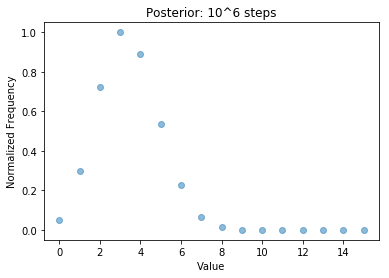

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, total_vals, alpha = 0.5, marker = 'o', linestyle = 'none')
ax.set_xlabel('Value')
ax.set_ylabel('Normalized Frequency')
ax.set_title('Posterior: 10^7 steps')
plt.show()


